In [488]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

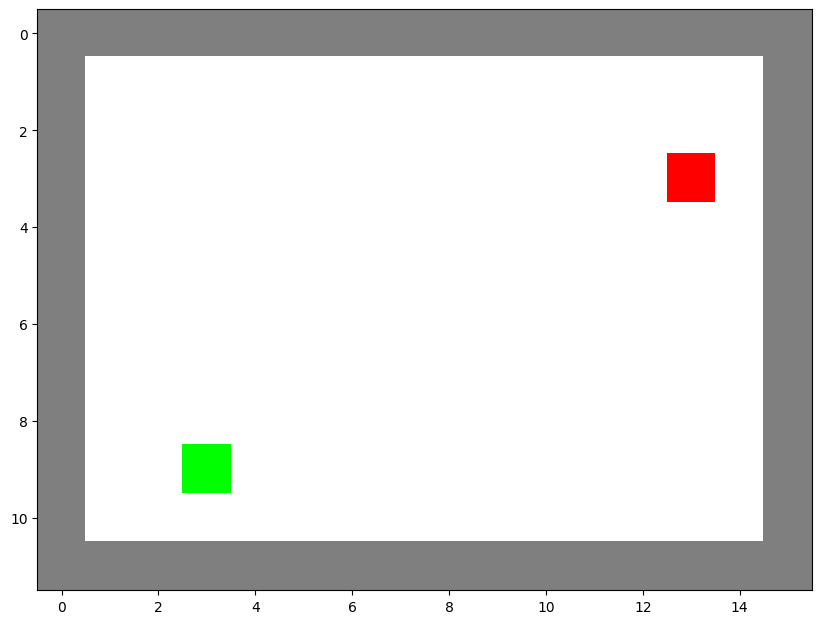

In [489]:
img = np.asarray(Image.open('pic2.png'))
imgplot = plt.imshow(img)

#### Class `Point`
Definiert einen Punkt mit folgenden Parametern:
- `x`: x-Position des Punktes
- `y`: y-Position des Punkter
- `cost`: Der Kostenwert um diesen Punkt zu erreichen
- `isActive`: Besagt ob der Punkt aktiv ist bzw. ob er für den Pfad relevant ist
- `distanceToTarget`: Ist die Distanz zum Ziel

In [490]:
class Point:
    def __init__(self, x, y, cost=-1, isActive=False, distanceToTarget=-1):
        self.x = x
        self.y = y
        self.cost = cost
        self.isActive = isActive,
        self.distanceToTarget = distanceToTarget

#### Function `getPointByColor`
Gibt einen Punkt zurück, welcher die entsprechende Farbe hat. Es wird nur der letzte gefundene Punkt zurückgegeben.
- `r`: Rotwert von 0-255
- `g`: Grünwert von 0-255
- `b`: Blauwert von 0-255
- `image`: Bildarray in dem der Punkt gesucht werden soll

In [491]:
def getPointByColor(r, g, b, image):
    x, y = 0, 0
    for idi, i in enumerate(image):
        for idj, j in enumerate(i):
            if j[0] == r and j[1] == g and j[2] == b:
               x = idj
               y = idi
    return Point(x ,y)


Der grüne Startpunkt und der rote Zielpunkt wird mithilfe der Funktion `getPointByColor` definiert.

In [492]:
startPoint = getPointByColor(0, 255, 0, img)
endPoint = getPointByColor(255, 0, 0, img)
print(f'StartPoint = {startPoint}\nEndPoint = {endPoint}')

StartPoint = <__main__.Point object at 0x174bb9510>
EndPoint = <__main__.Point object at 0x174cfb2b0>


#### Function `isWall`
Gibt zurück, ob entsprechneder Punkt eine Wand ist oder nicht. Wenn die Farbe des Punktes in allen drei Farben einen geringeren Wert als 128 aufweisst, wird er als Wand definiert.
- `point:Point`: Punkt der auf eine Wand geprüft werden soll.
- `image`: Bildarray auf dem der Punkt ist

In [493]:
def isWall(point:Point, image):
    x = point.x
    y = point.y
    if image[y][x][0] < 128 and image[y][x][1] < 128 and image[y][x][2] < 128: return True
    else: return False



def getDistance(pointStart:Point, pointTarget:Point):
    return np.sqrt(np.abs(pointStart.x-pointTarget.x)**2 + np.abs(pointStart.y-pointTarget.y)**2)

#### Function `getNextPoints`
Gibt eine List von Punkten zurück, die vom gegebenen Punkt benachbart sind. Wenn ein benachbarter Punkt eine Wand darstellt, wird dieser ignoriert.
- `point:Point`: Punkt von dem aus die benachbarten Punkte gesucht werden
- `image`: Bildarray auf dem der Punkt ist

In [494]:
def getNextPoints(point:Point, image):
    x = point.x
    y = point.y
    maxPos = image.shape
    nextPoints = []
    for i in np.arange(-1,2,1):
        for j in np.arange(-1,2,1):
            if i != 0 or j != 0:
                xn = x+i
                yn = y+j
                if xn >= 0 and yn >= 0 and xn <= maxPos[1] and yn <= maxPos[0] and not isWall(Point(xn, yn), image):
                    nextPoints.append(Point(xn, yn))
    return nextPoints

#### Function `calculateNextPoints`
Gibt eine List von Punkten zurück, die benachbart sind vom gegeben Punkt und berechnet die Kosten um den Punkt zu erreichen und berechnet die Distanz zum Zielpunkt.
- `point:Point`: Punkt von dem aus die benachbarten Punkte berechnet werden
- `image`: Bildarray auf dem der Punkt ist
- `precision`: Auf wieviele Stellen nach dem Komma gerundet werden soll bezüglich der Kosten

In [495]:
def calculateNextPoints(point:Point, image, precision=1):
    distance = 1
    distanceDiagonal = np.sqrt(distance**2 + distance**2)
    nextPoints = getNextPoints(startPoint, image)

    pointList = []
    for point in nextPoints:
        dist = 0
        if point.x != startPoint.x and point.y != startPoint.y:
            dist = round(distanceDiagonal,precision)
        else:
            dist = distance

        distanceToTarget = getDistance(point, endPoint)
        pointList.append(Point(point.x, point.y, dist, True, distanceToTarget))

    return pointList

In [496]:
def plotImage(image, points):
    for point in points:
        label = f'c={point.cost}\nd={round(point.distanceToTarget,1)}'
        plt.text(point.x, point.y, label, ha='center',va='center',fontsize=8)
    plt.imshow(image)

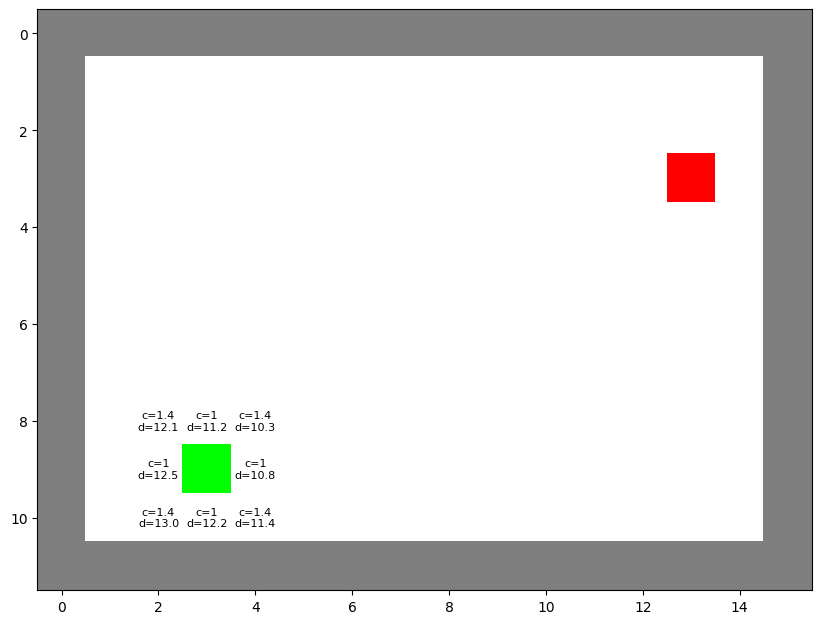

In [497]:
plotImage(img, calculateNextPoints(startPoint, img))

In [498]:
def getClosestPointToTarget(points):
    bestPoint:Point = 0
    minDistanceToTarget = float('inf')
    for point in points:
        if point.distanceToTarget < minDistanceToTarget:
            minDistanceToTarget = point.distanceToTarget
            bestPoint = point

    return bestPoint

In [499]:
nextPoints = calculateNextPoints(startPoint, img)
bestPoint = getClosestPointToTarget(nextPoints)
print(bestPoint.x, bestPoint.y, bestPoint.cost, bestPoint.distanceToTarget)

4 8 1.4 10.295630140987
